In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import struct

from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier 

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, train_test_split

from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt

from copy import deepcopy as copy

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# RF regressor optimization code

In [3]:
# hyperopt for lightgbm shows terrible results
def hyperopt_optimization_lightgbm(X, y, cv=6, max_iter_opt=15):
    space = hp.choice('clr_type', [
        {
            'type': 'lightgbm',
            'feature_fraction': hp.uniform('feature_fraction', 0.05, 0.95),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.05, 0.95),
            'bagging_freq': hp.uniform('bagging_freq', 1, 50),
            'n_estimators': hp.uniform('n_estimators', 5, 50),
            #'max_bin': hp.uniform('max_bin', )
        }
    ])

    best = fmin(
        fn=lambda args: cross_val_score(
            LGBMClassifier(
                boosting_type='rf', 
                feature_fraction=args['feature_fraction'], 
                bagging_freq=int(args['bagging_freq']), 
                bagging_fraction=args['bagging_fraction'],
                n_estimators=int(args['n_estimators'])
            ),
            X, y.squeeze(), cv=KFold(n_splits=cv).split(X), scoring='accuracy'
        ).mean(),
        space=space,
        algo=tpe.suggest,
        max_evals=max_iter_opt
    )
    
    return best

def bayesian_optimization_lightgbm(X, y, cv=6, max_iter_opt=15):
    svr_opt = BayesianOptimization(
        lambda feature_fraction, bagging_freq, bagging_fraction, n_estimators: cross_val_score(
            LGBMClassifier(
                boosting_type='rf', 
                feature_fraction=feature_fraction, 
                bagging_freq=int(bagging_freq), 
                bagging_fraction=bagging_fraction,
                n_estimators=int(n_estimators)
            ),
            X, y.squeeze(), cv=KFold(n_splits=cv).split(X), scoring='accuracy'
        ).mean(),
        {'feature_fraction': (0.05, 0.95),
         'bagging_fraction': (0.05, 0.95),
         'bagging_freq': (1, 50),
         'n_estimators': (5, 50) },
        verbose=0
    )
    
    svr_opt.init(10)
    svr_opt.maximize(init_points=10, n_iter=max_iter_opt)
    
    return svr_opt.res['max']['max_params']#['C']

# MNIST

In [4]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [5]:
X = read_idx('../../../datasets/mnist/train-images.idx3-ubyte')
y = read_idx('../../../datasets/mnist/train-labels.idx1-ubyte')

In [6]:
X = X / np.max(X)

In [7]:
X = X.reshape(X.shape[0], -1)

In [8]:
X = X[:1000, :]
y = y[:1000]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [10]:
print('dataset size: {}'.format(X.shape))

dataset size: (1000, 784)


### Training model with LLE-processed data

In [11]:
# number of components is fixed to 10
lle = LLE(n_components=10)
X_lle = lle.fit_transform(X_train)
X_val_lle = lle.transform(X_val)

In [12]:
X_lle, y_train = shuffle(X_lle, y_train)

### * Estimating LightGBM params

In [18]:
params_opt = hyperopt_optimization_lightgbm(X_lle, y_train, cv=4, max_iter_opt=10)

In [19]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [20]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000, tol=1e-2),
}

### * Evaluate with CV

In [21]:
stats = {}

for n_components in range(1, 11):
    print('n_components: {}'.format(n_components))
    stats[n_components] = {'cv': dict(), 'val': dict()}
    
    lle = LLE(n_components=n_components)
    X_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    for k, model in models.items():
        stats[n_components]['cv'][k] = []
        kfold = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for train_ix, test_ix in kfold.split(X_lle, y_train):
            _model = copy(model)
            
            X_crossval_train, X_crossval_test = X_lle[train_ix], X_lle[test_ix]
            y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]

            # here must be sume sort of optimization
            _model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[n_components]['cv'][k].append(accuracy_score(_model.predict(X_crossval_test), y_crossval_test, normalize=True))
        print('- cv for ' + k + ' is ready')
    
    for name, model in models.items():
        _model = copy(model)
        _model.fit(X_lle, y_train.squeeze())
        stats[n_components]['val'][name] = accuracy_score(_model.predict(X_val_lle), y_val.squeeze())

n_components: 1
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 2
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 3
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 4
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 5
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 6
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 7
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 8
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 9
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 10
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready


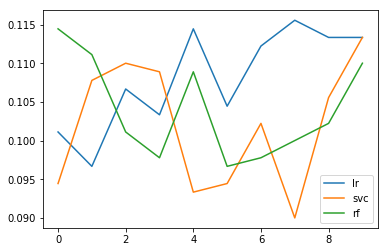

In [22]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['cv']['lr'])
    svm_cv = np.mean(_stats['cv']['svc'])
    rf_cv = np.mean(_stats['cv']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

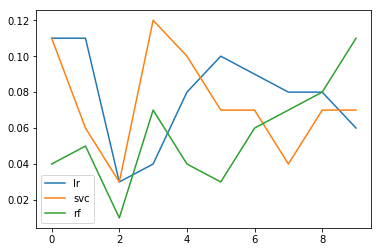

In [23]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['val']['lr'])
    svm_cv = np.mean(_stats['val']['svc'])
    rf_cv = np.mean(_stats['val']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

# Credit Card Fraud

In [24]:
df = pd.read_csv('../../../datasets/creditcard/creditcard.csv')

In [25]:
X = df[np.setdiff1d(df.columns, ["Class", "Time"])].values
y = df.Class.values

In [26]:
X = X[:6000, :]
y = y[:6000]

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [28]:
print('dataset size: {}'.format(X.shape))

dataset size: (6000, 29)


### Training model with LLE-processed data

In [29]:
# number of components is fixed to 10
lle = LLE(n_components=10)
X_lle = lle.fit_transform(X_train)
X_val_lle = lle.transform(X_val)

In [30]:
X_lle, y_train = shuffle(X_lle, y_train)

### * Estimating LightGBM params

In [31]:
params_opt = hyperopt_optimization_lightgbm(X_lle, y_train, cv=4, max_iter_opt=10)

In [32]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [33]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000, tol=1e-2),
}

In [34]:
stats = {}

for n_components in range(1, 11):
    print('n_components: {}'.format(n_components))
    stats[n_components] = {'cv': dict(), 'val': dict()}
    
    lle = LLE(n_components=n_components)
    X_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    for k, model in models.items():
        stats[n_components]['cv'][k] = []
        kfold = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for train_ix, test_ix in kfold.split(X_lle, y_train):
            _model = copy(model)
            
            X_crossval_train, X_crossval_test = X_lle[train_ix], X_lle[test_ix]
            y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]

            # here must be sume sort of optimization
            _model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[n_components]['cv'][k].append(accuracy_score(_model.predict(X_crossval_test), y_crossval_test, normalize=True))
        print('- cv for ' + k + ' is ready')
    
    for name, model in models.items():
        _model = copy(model)
        _model.fit(X_lle, y_train.squeeze())
        stats[n_components]['val'][name] = accuracy_score(_model.predict(X_val_lle), y_val.squeeze())

n_components: 1
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 2
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 3
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 4
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 5
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 6
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 7
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 8
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 9
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 10
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready


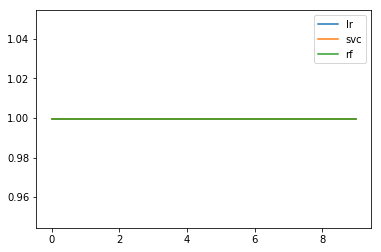

In [35]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['cv']['lr'])
    svm_cv = np.mean(_stats['cv']['svc'])
    rf_cv = np.mean(_stats['cv']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

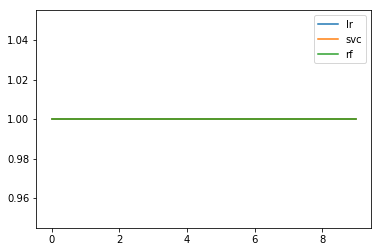

In [36]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['val']['lr'])
    svm_cv = np.mean(_stats['val']['svc'])
    rf_cv = np.mean(_stats['val']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

# Breast Cancer

In [37]:
df = pd.read_csv('../../../datasets/cancer/breast_cancer.csv')
y = df.diagnosis.replace('M', 0).replace('B', 1).values
X = np.asarray(df.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1).as_matrix())

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [39]:
print('dataset size: {}'.format(X.shape))

dataset size: (569, 30)


### Training model with LLE-processed data

In [40]:
# number of components is fixed to 10
lle = LLE(n_components=10)
X_lle = lle.fit_transform(X_train)
X_val_lle = lle.transform(X_val)

In [41]:
X_lle, y_train = shuffle(X_lle, y_train)

### * Estimating LightGBM params

In [42]:
params_opt = hyperopt_optimization_lightgbm(X_lle, y_train, cv=4, max_iter_opt=10)

In [43]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [44]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000),
}

In [45]:
stats = {}

for n_components in range(1, 11):
    print('n_components: {}'.format(n_components))
    stats[n_components] = {'cv': dict(), 'val': dict()}
    
    lle = LLE(n_components=n_components)
    X_lle = lle.fit_transform(X_train)
    X_val_lle = lle.transform(X_val)
    
    for k, model in models.items():
        stats[n_components]['cv'][k] = []
        kfold = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for train_ix, test_ix in kfold.split(X_lle, y_train):
            _model = copy(model)
            
            X_crossval_train, X_crossval_test = X_lle[train_ix], X_lle[test_ix]
            y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]

            # here must be sume sort of optimization
            _model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[n_components]['cv'][k].append(accuracy_score(_model.predict(X_crossval_test), y_crossval_test, normalize=True))
        print('- cv for ' + k + ' is ready')
    
    for name, model in models.items():
        _model = copy(model)
        _model.fit(X_lle, y_train.squeeze())
        stats[n_components]['val'][name] = accuracy_score(_model.predict(X_val_lle), y_val.squeeze())

n_components: 1
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 2
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 3
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 4
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 5
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 6
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 7
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 8
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 9
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 10
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready


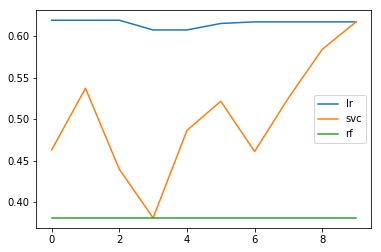

In [46]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['cv']['lr'])
    svm_cv = np.mean(_stats['cv']['svc'])
    rf_cv = np.mean(_stats['cv']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

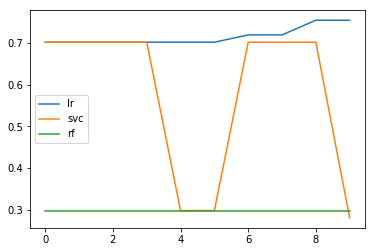

In [47]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['val']['lr'])
    svm_cv = np.mean(_stats['val']['svc'])
    rf_cv = np.mean(_stats['val']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()